#### Task 1: Financial Time-Series Anomaly Detection  
##### Objective: Build a tool to identify anomalies in stock price trends to detect unusual activities or market manipulations.  
● Dataset: Yahoo Finance Stock Market Dataset  
● Steps:  
1. Download and preprocess historical stock price data for a few chosen 
companies. 
2. Calculate financial indicators (e.g., SMA, EMA, RSI, Bollinger Bands). 
3. Use Isolation Forest or DBSCAN for unsupervised anomaly detection.  
4. Build a time-series forecasting model using LSTM or Prophet to identify 
deviations.  
5. Visualize detected anomalies on stock price trends.  
● Outcome: A tool or report identifying anomalies in stock price trends  
and possible market manipulations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler


In [2]:
data = pd.read_excel("data/yahoo_data.xlsx")
data.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000


In [3]:
data.shape

(1258, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1258 non-null   object 
 1   Open         1258 non-null   float64
 2   High         1258 non-null   float64
 3   Low          1258 non-null   float64
 4   Close*       1258 non-null   float64
 5   Adj Close**  1258 non-null   float64
 6   Volume       1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


````---> LowerCasing the columns name````

```---> Removing extra spaces in columns name```

```---> Standarizing the column name```

In [5]:
data.columns = data.columns.str.lower().str.strip()

In [6]:
data.rename(columns={"close*":"close","adj close**":"adj_close"},inplace=True)

In [7]:
data["date"] = pd.to_datetime(data["date"])

In [8]:
data.isna().sum()

date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [9]:
data =  data.sort_values("date")   # Sorting the data on the basis of date columns 

In [10]:
data = data.set_index("date")  #  Date as Index 
data.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2018-05-01,24117.29,24117.29,23808.19,24099.05,24099.05,380070000
2018-05-02,24097.63,24185.52,23886.30,23924.98,23924.98,385350000
2018-05-03,23836.23,23996.15,23531.31,23930.15,23930.15,389240000
2018-05-04,23865.22,24333.35,23778.87,24262.51,24262.51,329480000
2018-05-07,24317.66,24479.45,24263.42,24357.32,24357.32,307670000


## Financial Indicators

In [11]:

import ta  # Technical Analysis(ta)is a  Library in Python, that provides a wide range of technical analysis indicators. These indicators are commonly used for analyzing financial market data, such as stock prices, forex, and cryptocurrency markets.

data["sma"] = ta.trend.sma_indicator(data["close"],window=20) # This line adds a Simple Moving Average (SMA) to the data. The SMA is calculated by averaging the closing price over the past 20 periods

data["ema"] = ta.trend.ema_indicator(data["close"],window=20)  # Exponential Moving Average (EMA). EMA gives more weight to recent prices, making it more responsive to price changes.

data["rsi"] = ta.momentum.rsi(data["close"],window=20)  # Relative Strength Index (RSI). RSI is a momentum oscillator that measures the speed and change of price movements. It ranges from 0 to 100 and is commonly used to identify overbought or oversold conditions in a market.

data.dropna(inplace=True)  # drop all empty values 


#### Bollinger Bands
Bollinger Bands consist of three lines:

The ``middle band`` is a Simple Moving Average (SMA) of the closing price.

The ``upper band`` (the Bollinger high band) is the middle band + a multiple of the standard deviation of the price. This is controlled by the window_dev parameter. Here, window_dev=2 means that the upper band will be 2 standard deviations above the middle band.

The ``lower band`` (the Bollinger low band) is the middle band - the same multiple of the standard deviation. Again, with window_dev=2, it will be 2 standard deviations below the middle ban

In [12]:
bb = ta.volatility.BollingerBands(data["close"],window=20,window_dev=2)

data["bb_high"] = bb.bollinger_hband()   # Bollinger Low band
data["bb_low"] = bb.bollinger_lband()   # Bollinger high Band

data.dropna(inplace=True)

### Anomly Detection Using Isolation Forest

In [13]:
from sklearn.ensemble import IsolationForest
features = ["close","sma","ema","rsi","bb_high","bb_low"]
model = IsolationForest(contamination="auto",random_state=42,n_estimators=80)
data["anomly"] = model.fit_predict(data[features])  #  Isolation Forest returns -1 and 1 as output by default

In [14]:
data["anomly"] = data["anomly"].map({1:0,-1:1})  # where 1 means anomly   

In [15]:
data.head()

,open,high,low,close,adj_close,volume,sma,ema,rsi,bb_high,bb_low,anomly
date,,,,,,,,,,,,
2018-06-25,24463.73,24463.73,24084.39,24252.80,24252.80,439130000,24857.4590,24781.278138,40.424594,25544.147367,24170.770633,0
2018-06-26,24281.89,24384.21,24241.22,24283.11,24283.11,301130000,24853.5420,24733.833554,41.188323,25552.290818,24154.793182,0
2018-06-27,24303.11,24569.02,24115.82,24117.59,24117.59,313790000,24826.0325,24675.143692,38.361436,25591.960947,24060.104053,0
2018-06-28,24064.19,24308.16,23997.21,24216.05,24216.05,305020000,24816.0430,24631.420483,40.901230,25607.883500,24024.202500,0
2018-06-29,24323.93,24509.52,24269.71,24271.41,24271.41,329070000,24797.8530,24597.133770,42.308162,25621.547591,23974.158409,0


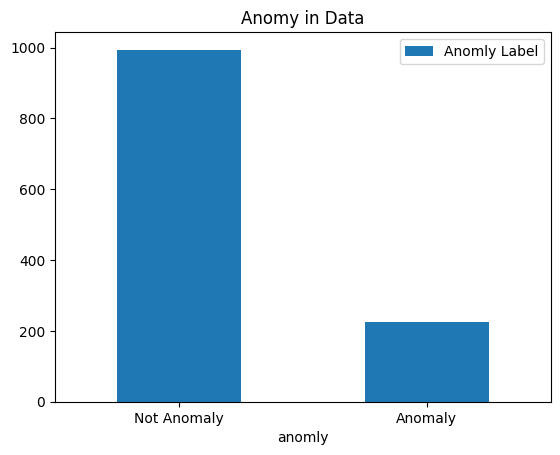

In [20]:
data["anomly"].value_counts().plot(kind="bar")   # where 1 mean anomly
plt.title("Anomy in Data")
plt.xticks(ticks=[0, 1], labels=["Not Anomaly", "Anomaly"], rotation=0)
plt.legend(["Anomly Label"])
plt.show()

In [22]:
import tensorflow
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler

In [23]:
data.head()

,open,high,low,close,adj_close,volume,sma,ema,rsi,bb_high,bb_low,anomly
date,,,,,,,,,,,,
2018-06-25,24463.73,24463.73,24084.39,24252.80,24252.80,439130000,24857.4590,24781.278138,40.424594,25544.147367,24170.770633,0
2018-06-26,24281.89,24384.21,24241.22,24283.11,24283.11,301130000,24853.5420,24733.833554,41.188323,25552.290818,24154.793182,0
2018-06-27,24303.11,24569.02,24115.82,24117.59,24117.59,313790000,24826.0325,24675.143692,38.361436,25591.960947,24060.104053,0
2018-06-28,24064.19,24308.16,23997.21,24216.05,24216.05,305020000,24816.0430,24631.420483,40.901230,25607.883500,24024.202500,0
2018-06-29,24323.93,24509.52,24269.71,24271.41,24271.41,329070000,24797.8530,24597.133770,42.308162,25621.547591,23974.158409,0


In [39]:
sc = StandardScaler()
x = sc.fit_transform(data.drop(columns="anomly"))
y = data["anomly"].values

In [ ]:
# We create this function to split our time series data into windows 
# LSTMs are designed to understand patterns over time. But they don’t "know" where a sequence starts or ends unless we explicitly give them that.So instead of sending the entire dataset as one big flat list of rows, we send it as overlapping sequences, like sliding windows

import numpy as np
def create_Sequence(data, labels, seq_len):   # seq_len = window per each step
    x_seq, y_seq = [], []
    for i in range(len(data) - seq_len):   # len(data) - seq_len. This ensures you don't go out of bounds when slicing.
        x_seq.append(data[i:i+seq_len])    # first i = 0:30 then 1:31  , 2:32 .....
        y_seq.append(labels[i + seq_len])  # Use the label just after the sequence  30,31,32,33
    return np.array(x_seq), np.array(y_seq)


sequence_length = 30
x_seq, y_seq = create_Sequence(x, y, sequence_length)

In [41]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(30,11)))
model.add(LSTM(50))
model.add(Dense(1,activation="sigmoid"))
model.summary()

c:\Users\hasee\Desktop\Part 2\P1\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 50)         │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,651 (127.54 KB)

 Trainable params: 32,651 (127.54 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(optimizer="adam",loss="mse",metrics=["accuracy"])

In [44]:
history = model.fit(x_seq,y_seq,epochs=10,validation_split=0.1)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9342 - loss: 0.0513 - val_accuracy: 0.9496 - val_loss: 0.0421
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9490 - loss: 0.0429 - val_accuracy: 0.9160 - val_loss: 0.0544
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9187 - loss: 0.0601 - val_accuracy: 0.9580 - val_loss: 0.0325
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9491 - loss: 0.0460 - val_accuracy: 0.9076 - val_loss: 0.0611
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9257 - loss: 0.0601 - val_accuracy: 0.8992 - val_loss: 0.0678
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9557 - loss: 0.0390 - val_accuracy: 0.9076 - val_loss: 0.0668
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9402 - loss: 0.0505 - val_accuracy: 0.8992 - val_loss: 0.0679
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9580 - loss: 0.0377 - val_accuracy: 0.8992 - v

#### Since Data is quite small validation loss is high compare to training loss

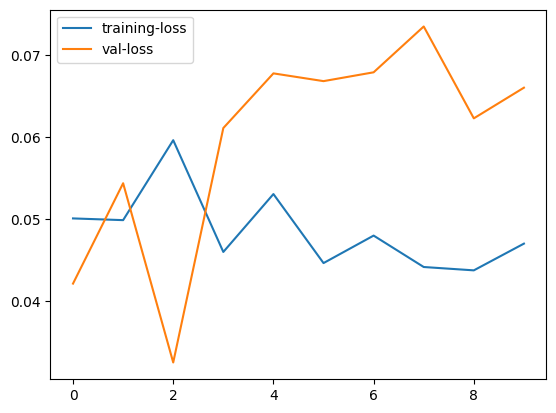

In [ ]:
plt.plot(history.history["loss"],label="training-loss")
plt.plot(history.history["val_loss"],label="val-loss")
plt.legend()
plt.show()

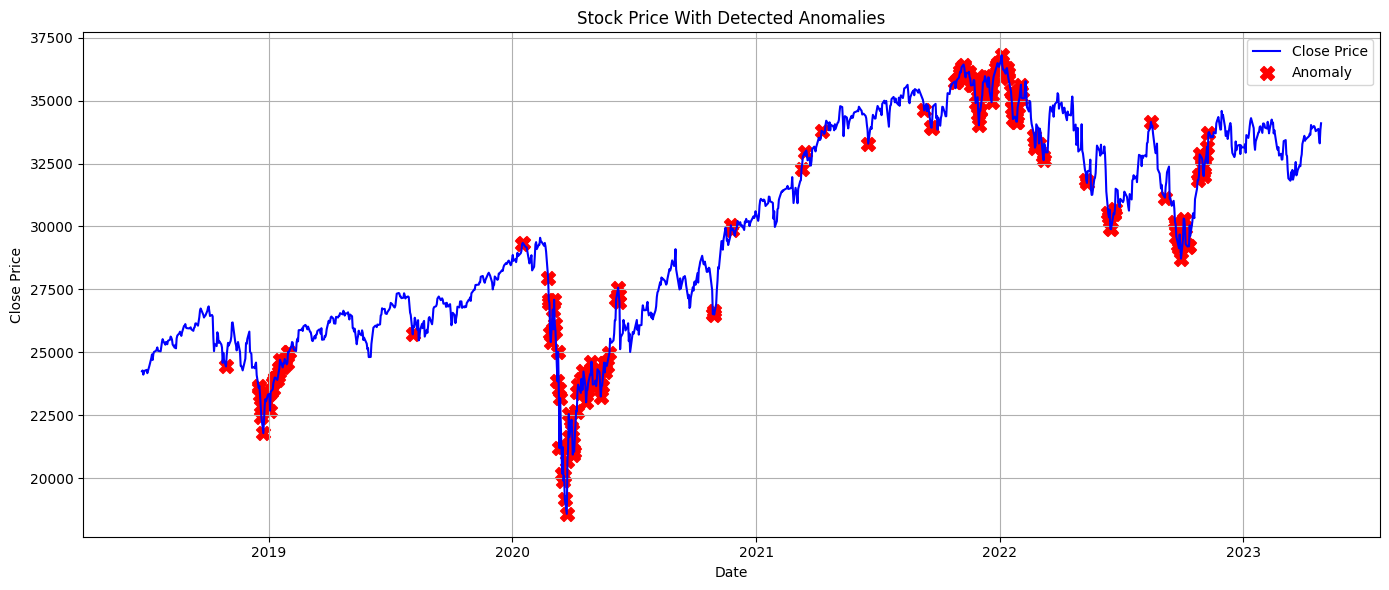

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(data.index,data["close"],label="Close Price",color="Blue")

plt.scatter(data[data["anomly"]==1].index,
            data[data["anomly"]==1]["close"],
            color="red",
            label="Anomaly",
            marker="X",
            s=100)

plt.title("Stock Price With Detected Anomalies")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()